# Task 1 : Set up colab gpu runtime environment

In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

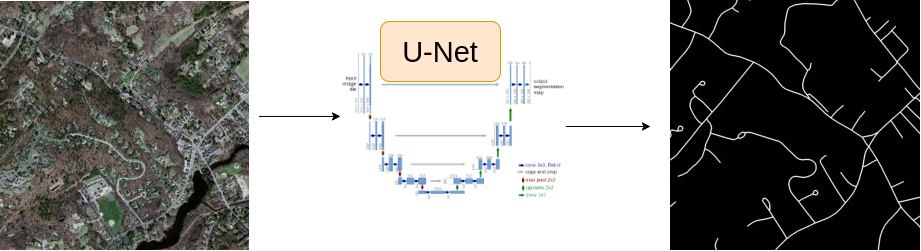

# Download Subset Dataset

In [4]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 20.95 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [5]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [7]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'
EPOCH = 25
LR = 9.993
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head(5)

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [9]:
idx = 3
image_path = DATA_DIR + df['images'].iloc[idx]
mask_path = DATA_DIR + df['masks'].iloc[idx]
image = cv2.imread(image_path,cv2.IMREAD_COLOR)
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

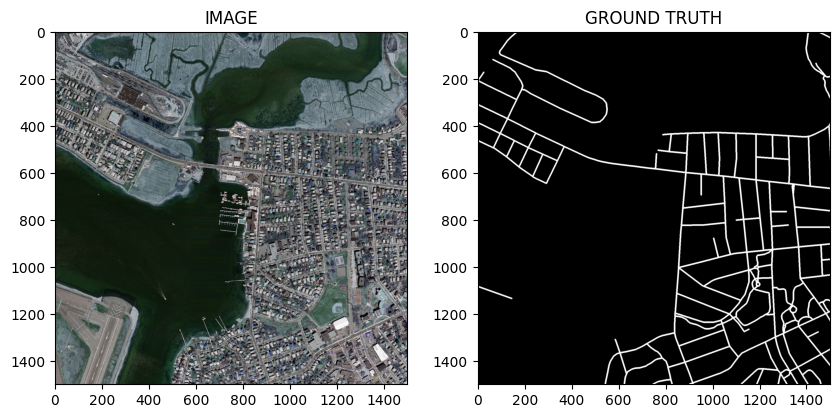

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df,val_df = train_test_split(df,test_size = 0.2, random_state= 42)
len(train_df)


159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p= 0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset


In [15]:
class SegmentationData(Dataset):
  def __init__(self,df,augmentations):
    self.df =df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    image = cv2.imread(image_path,cv2.IMREAD_COLOR) #(h,w,c)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask,axis= -1) #(h,w,c)
    #print(mask.shape)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) #return a dictionary
      image = data['image']
      mask = data['mask']
      #print(mask.shape)

    image = np.transpose(image,(2,0,1)).astype(np.float32) #(channel,h,w)
    mask =  np.transpose(mask,(2,0,1)).astype(np.float32) #(channel,h,w)
    image = torch.tensor(image)/255 #making the float to 0 to 1
    mask = torch.round(torch.tensor(mask)/255) #making the float to 0 to 1
    return image,mask

In [16]:
train_dataset = SegmentationData(train_df,get_train_augs())
valid_dataset = SegmentationData(val_df,get_valid_augs())

In [17]:
len(train_dataset)

159

In [18]:
idx = 3
image,mask = train_dataset[idx]

In [19]:
mask.shape

torch.Size([1, 512, 512])

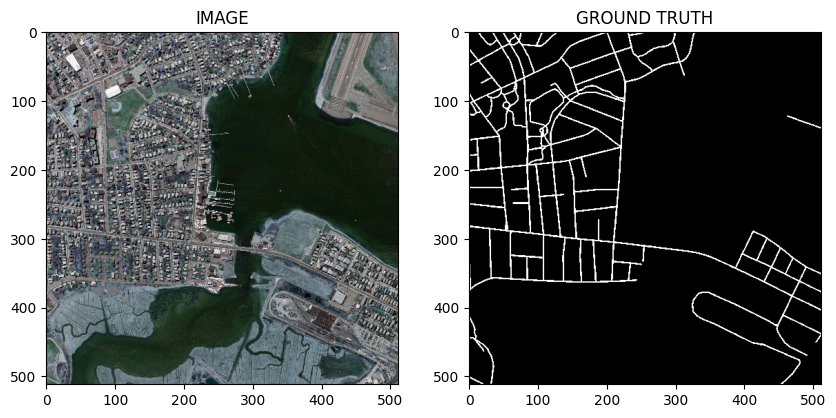

In [20]:
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [21]:
from torch.utils.data import DataLoader

In [22]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size= BATCH_SIZE)


In [23]:
print(f'Total number of images in train set : {len(train_dataset)}')
print(f'Total number of images in validation set : {len(valid_dataset)}')

Total number of images in train set : 159
Total number of images in validation set : 40


In [24]:
print(f'Total number of batches in train loader : {len(train_loader)}')
print(f'Total number of batches in validation loader : {len(valid_loader)}')

Total number of batches in train loader : 20
Total number of batches in validation loader : 5


In [25]:
for images,mask in train_loader:
  print(images.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


In [26]:
for images,mask in valid_loader:
  print(images.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [28]:

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn


In [35]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self,images,masks = None):
    logits = self.backbone(images)
    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits,masks)+nn.BCEWithLogitsLoss()(logits,masks)

    return logits

In [36]:
model = SegmentationModel().to(DEVICE)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Task 7 : Create Train and Validation Function

In [31]:
def train_fn(data_loader,model,optimizer):
  model.train() #to turn on the dropout,batchnorm etc
  total_loss = 0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad() # making the greadients zero
    logits,loss = model(images,masks)
    loss.backward() # fixing the gradients by loss
    optimizer.step() #updating the gradients
    total_loss += loss.item()
  return total_loss/len(data_loader)

In [32]:
def eval_fn(data_loader,model):
  model.eval() #to turn on the dropout,batchnorm etc
  total_loss = 0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      #optimizer.zero_grad() # making the greadients zero
      logits,loss = model(images,masks)
      #loss.backward() # fixing the gradients by loss
      #optimizer.step() #updating the gradients
      total_loss += loss.item()
  return total_loss/len(data_loader)




# Task 8 : Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

NameError: name 'model' is not defined

In [37]:
best_loss = np.inf
train_losses = []
valid_losses = []
for i in range(EPOCH):
  train_loss = train_fn(train_loader,model,optimizer)
  valid_loss = eval_fn(valid_loader,model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    torch.save({
    'epoch': i+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss
      }, 'best_model.pth')

  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')
# ✅ After training, plot the graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCH + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, EPOCH + 1), valid_losses, label="Valid Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

# Task 9 : Inference

In [ ]:
idx = 7
model.load_state_dict(torch.load('best_model.pth'))
image,mask = valid_dataset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #logits are the raw output without sigmoid or activation function , so the model ouput is (c,h,w ) but fpr prediction it needs batch. that's wht the squeex, it will add a extra dimension for batch
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0  #making 0 and 1 for binary segmentation
pred_mask = pred_mask.detach().cpu().squeeze(0) # so for printing the predicted image we need to remove the batch.


In [ ]:
helper.show_image(image,mask,pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

